### Course objectives

* The objective is to learn how to write shared-memory Python programs that make use of multiple cores on
  a single node. The tutorial will introduce several python modules that schedule operations and manage
  data to simplify multiprocessing with Python.

1. Benchmarking parallel code
1. Understanding the global interpreter lock (GIL)
1. Multiprocessing and multithreading with [joblib](https://pythonhosted.org/joblib/)
1. Checkpointing/restarting multiprocessor jobs
1. Multithreaded file i/o with [zarr](http://zarr.readthedocs.io/en/latest/) and [parquet](https://arrow.apache.org/docs/python/parquet.html)
1. Writing extensions that release the GIL:
   1.  Using [numba](http://numba.pydata.org/)
   1.  Using [cython](http://cython.org/)
   1.  Using C++ and [pybind11](http://pybind11.readthedocs.io/en/stable/?badge=stable) with [xtensor-python](https://xtensor-python.readthedocs.io/en/latest/)
1. Using [dask](http://dask.pydata.org/en/latest/)/[xarray](http://xarray.pydata.org/en/stable/dask.html) to analyze out-of-core datasets
1. Visualizing parallelization with dask
1. Setting up a conda-forge environment for parallel computing




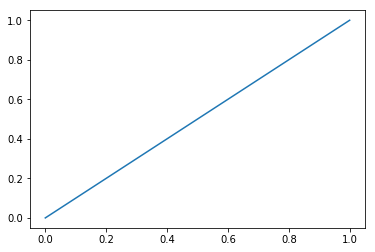

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot([0,1],[0,1])


In [7]:
import numpy
import thread_tools as tt
print(tt.get_thread_id())
help(tt)
print(tt.__file__)

4fdf76a5
Help on module thread_tools:

NAME
    thread_tools

DESCRIPTION
    Pybind11 example plugin
    -----------------------
    
    .. currentmodule:: thread_tools
    
    .. autosummary::
       :toctree: _generate
    
       thread_sleep
       get_thread_id

FUNCTIONS
    get_thread_id(...) method of builtins.PyCapsule instance
        get_thread_id() -> str
    
    test_numpy(...) method of builtins.PyCapsule instance
        test_numpy(arg0: numpy.ndarray[float]) -> None
    
    test_numpy2(...) method of builtins.PyCapsule instance
        test_numpy2(arg0: numpy.ndarray[float]) -> None
    
    thread_sleep_gil(...) method of builtins.PyCapsule instance
        thread_sleep_gil(arg0: float) -> None
        
        
        thread_sleep(nsecs)
        
        Sleep a thread for a specified time in seconds holding the gil
         
        Parameters
        ----------
        
        nsecs: float
          fractional number of seconds to sleep
        
        Retur

In [8]:
from multiprocessing.pool import ThreadPool, Pool
import pdir
print(pdir(ThreadPool))

attribute access:
    __delattr__, __dir__, __getattribute__, __setattr__
class customization:
    __init_subclass__, __subclasshook__
context manager:
    __enter__, __exit__
object customization:
    __format__, __hash__, __init__, __new__, __repr__, __sizeof__, __str__
other:
    _wrap_exception
pickle:
    __reduce__, __reduce_ex__
rich comparison:
    __eq__, __ge__, __gt__, __le__, __lt__, __ne__
special attribute:
    __class__, __dict__, __doc__, __module__, __weakref__
function:
    Process: 
    _get_tasks: 
    _handle_results: 
    _handle_tasks: 
    _handle_workers: 
    _help_stuff_finish: 
    _join_exited_workers: Cleanup after any worker processes which have exited due to reaching
    _maintain_pool: Clean up any exited workers and start replacements for them.
    _map_async: Helper function to implement map, starmap and their async counterparts.
    _repopulate_pool: Bring the number of pool processes up to the specified number,
    _setup_queues: 
    _terminate_poo

In [9]:
import time
import contexttimer
import itertools
import numpy as np

def make_sleep(task_dict):
    def nogil(sleep_time,tasknum):
        tt.thread_sleep_nogil(sleep_time)
        thread_id=tt.get_thread_id()
        thread_num=task_dict[thread_id]
        print(f'task {tasknum} sleeping for {sleep_time} seconds on thread {thread_num}\n')
    return nogil

def gil(sleep_time,tasknum):
    tt.thread_sleep_gil(sleep_time)
    thread_id=tt.get_thread_id()
    print(f'task {tasknum} sleeping for {sleep_time} seconds on thread {thread_id}\n')

def collect_threads(task_num):
    tt.thread_sleep_nogil(0.1)
    thread_id=tt.get_thread_id()
    return thread_id,task_num

def make_dict(task_list):
    task_dict=dict(task_list)
    for count,key in enumerate(task_dict.keys()):
        task_dict[key]=count
    return task_dict

def make_accum(npkeep,task_dict):
    def nogil(sleep_time,tasknum):
        tt.thread_sleep_gil(sleep_time)
        thread_id=tt.get_thread_id()
        thread_num=task_dict[thread_id]
        npkeep[thread_num]+=1
        print(f'task {tasknum} sleeping for {sleep_time} seconds on thread {thread_num}\n')
    return nogil
    
sleep=0.5
num_tasks=20
num_threads=5
sleep_iter=itertools.repeat(sleep,num_tasks)
args=zip(sleep_iter,range(num_tasks))

np_array=np.zeros(num_threads)
np_array=[0 for i in range(num_threads)]
with contexttimer.Timer(time.time) as wall:
    with contexttimer.Timer(time.perf_counter) as cpu:
       
        with ThreadPool(num_threads) as pool:
            task_list=pool.map(collect_threads,range(num_tasks))
            task_dict=make_dict(task_list)
            nogil=make_accum(np_array,task_dict)
            pool.starmap(nogil,args)
            
print(np_array)
            
print(wall.elapsed)
print(cpu.elapsed)

task 2 sleeping for 0.5 seconds on thread 2
task 0 sleeping for 0.5 seconds on thread 1
task 1 sleeping for 0.5 seconds on thread 3
task 4 sleeping for 0.5 seconds on thread 4
task 3 sleeping for 0.5 seconds on thread 0





task 5 sleeping for 0.5 seconds on thread 2
task 6 sleeping for 0.5 seconds on thread 3
task 7 sleeping for 0.5 seconds on thread 4
task 8 sleeping for 0.5 seconds on thread 0
task 9 sleeping for 0.5 seconds on thread 1





task 10 sleeping for 0.5 seconds on thread 4
task 11 sleeping for 0.5 seconds on thread 0
task 12 sleeping for 0.5 seconds on thread 2
task 13 sleeping for 0.5 seconds on thread 1
task 14 sleeping for 0.5 seconds on thread 3





task 15 sleeping for 0.5 seconds on thread 2
task 16 sleeping for 0.5 seconds on thread 1
task 17 sleeping for 0.5 seconds on thread 3
task 18 sleeping for 0.5 seconds on thread 4
task 19 sleeping for 0.5 seconds on thread 0





[4, 4, 4, 4, 4]
10.611523151397705
10.611103342147544


In [4]:
import itertools
help(itertools.repeat)

Help on class repeat in module itertools:

class repeat(builtins.object)
 |  repeat(object [,times]) -> create an iterator which returns the object
 |  for the specified number of times.  If not specified, returns the object
 |  endlessly.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __length_hint__(...)
 |      Private method returning an estimate of len(list(it)).
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __repr__(self, /)
 |      Return repr(self).

